# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# April 26, 2018

## Dynamic Experiments

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

# Literature / Useful References

### Books
- Jean Claude, Morphometry with R
 - [Online](http://link.springer.com/book/10.1007%2F978-0-387-77789-4) through ETHZ
 - [Buy it](http://www.amazon.com/Morphometrics-R-Use-Julien-Claude/dp/038777789X)
- John C. Russ, “The Image Processing Handbook”,(Boca Raton, CRC Press)
 - Available [online](http://dx.doi.org/10.1201/9780203881095) within domain ethz.ch (or proxy.ethz.ch / public VPN) 

 

### Papers / Sites

- Comparsion of Tracking Methods in Biology
 - Chenouard, N., Smal, I., de Chaumont, F., Maška, M., Sbalzarini, I. F., Gong, Y., … Meijering, E. (2014). Objective comparison of particle tracking methods. Nature Methods, 11(3), 281–289. doi:10.1038/nmeth.2808
 - Maska, M., Ulman, V., Svoboda, D., Matula, P., Matula, P., Ederra, C., … Ortiz-de-Solorzano, C. (2014). A benchmark for comparison of cell tracking algorithms. Bioinformatics (Oxford, England), btu080–. doi:10.1093/bioinformatics/btu080
 
- Multiple Hypothesis Testing
 - Coraluppi, S. & Carthel, C. Multi-stage multiple-hypothesis tracking.
J. Adv. Inf. Fusion 6, 57–67 (2011).
 - Chenouard, N., Bloch, I. & Olivo-Marin, J.-C. Multiple hypothesis
tracking in microscopy images. in Proc. IEEE Int. Symp. Biomed. Imaging
1346–1349 (IEEE, 2009).

 
# Previously on QBI ...

- Image Enhancment 
 - Highlighting the contrast of interest in images
 - Minimizing Noise
- Understanding image histograms
- Automatic Methods
- Component Labeling
- Single Shape Analysis
- Complicated Shapes
- Distribution Analysis

# Quantitative "Big" Imaging


The course has covered imaging enough and there have been a few quantitative metrics, but "big" has not really entered.

What does __big__ mean?

- Not just / even large
- it means being ready for _big data_
- volume, velocity, variety (3 V's)
- scalable, fast, easy to customize


So what is "big" imaging

- doing analyses in a disciplined manner
 - fixed steps
 - easy to regenerate results
 - no _magic_
- having everything automated
 - 100 samples is as easy as 1 sample
- being able to adapt and reuse analyses
 - one really well working script and modify parameters
 - different types of cells
 - different regions

# Objectives


1. What sort of dynamic experiments do we have?
1. How can we design good dynamic experiments?
1. How can we track objects between points?

How can we track shape?
How can we track distribution?

1. How can we track topology?
1. How can we track voxels?
1. How can we assess deformation and strain?
1. How can assess more general cases?

# Outline

- Motivation (Why and How?)
- Scientific Goals

### Experiments

- Simulations
- Experiment Design
 
### Object Tracking
### Distribution
### Topology


### Voxel-based Methods
 - Cross Correlation
 - DIC
 - DIC + Physics
 
### General Problems
 - Thickness - Lung Tissue
 - Curvature - Metal Systems
 - Two Point Correlation - Volcanic Rock

# Motivation


- 3D images are already difficult to interpret on their own
- 3D movies (4D) are almost impossible 

<video controls>
  <source src="../common/movies/dk31-plat.avi" type="video/avi">
Your browser does not support the video tag.
</video>



- 2D movies (3D) can also be challenging

<video controls>
  <source src="ext-figures/WaterJet.m4v" type="video/mp4">
Your browser does not support the video tag.
</video>


We can say that it looks like, but many pieces of quantitative information are difficult to extract
- how fast is it going?
- how many particles are present?
- are their sizes constant?
- are some moving faster?
- are they rearranging?

# Scientific Goals

### Rheology

Understanding the flow of liquids and mixtures is important for many processes
- blood movement in arteries, veins, and capillaries
- oil movement through porous rock
- air through dough when cooking bread
- magma and gas in a volcano


### Deformation

Deformation is similarly important since it plays a significant role in the following scenarios

- red blood cell lysis in artificial heart valves
- microfractures growing into stress fractures in bone
- toughening in certain wood types

# Experiments
The first step of any of these analyses is proper experimental design. Since there is always

- a limited field of view
- a voxel size
- a maximum rate of measurements
- a non-zero cost for each measurement


There are always trade-offs to be made between getting the best possible high-resolution nanoscale dynamics and capturing the system level behavior. 

#### If we measure too fast
 - sample damage
 - miss out on long term changes
 - have noisy data
 
#### Too slow
 - miss small, rapid changes
 - blurring and other motion artifacts
 
#### Too high resolution
 - not enough unique structures in field of view to track
 
#### Too low resolution
 - not sensitive to small changes

# Simulation

In many cases, experimental data is inherited and little can be done about the design, but when there is still the opportunity, simulations provide a powerful tool for tuning and balancing a large number parameters

Simulations also provide the ability to pair post-processing to the experiments and determine the limits of tracking.

# What do we start with?

Going back to our original cell image

1. We have been able to get rid of the noise in the image and find all the cells (lecture 2-4)
1. We have analyzed the shape of the cells using the shape tensor (lecture 5)
1. We even separated cells joined together using Watershed (lecture 6)
1. We have created even more metrics characterizing the distribution (lecture 7)

We have at least a few samples (or different regions), large number of metrics and an almost as large number of parameters to _tune_


### How do we do something meaningful with it?

# Basic Simulation


We start with a starting image with a number of circles on a plane

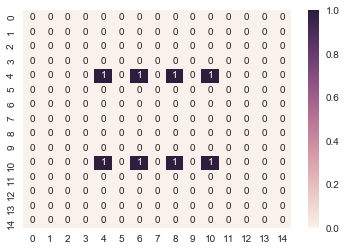

In [37]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 15),
                    np.linspace(-1.5, 1.5, 15))

N_DISK_ROW = 2
N_DISK_COL = 4
DISK_RAD = 0.15
disk_img = np.zeros(xx.shape, dtype = int)
for x_cent in 0.7*np.linspace(-1, 1, N_DISK_COL):
    for y_cent in 0.7*np.linspace(-1, 1, N_DISK_ROW):
        c_disk = np.sqrt(np.square(xx-x_cent)+np.square(yy-y_cent))<DISK_RAD
        disk_img[c_disk] = 1
fig, ax1 = plt.subplots(1,1)

sns.heatmap(disk_img, annot = True, fmt = 'd', ax = ax1);

In [51]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, c_ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

s_img = disk_img.copy()
img_list = [s_img]
for i in range(4):
    s_img = np.roll(s_img, -1, axis = 1)
    s_img = np.roll(s_img, -1, axis = 0)
    img_list += [s_img]

def update_frame(i):
    plt.cla()
    sns.heatmap(img_list[i],
                annot=True,
                fmt="d",
                cmap='nipy_spectral',
                ax=c_ax,
                cbar=False,
                vmin=0,
                vmax=1)
    c_ax.set_title('Iteration #{}'.format(i+1))


# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=len(img_list),
                          interval=1000,
                          repeat_delay=2000).to_html5_video()
plt.close('all')
HTML(anim_code)

### Analysis

- Threshold
- Component Label
- Shape Analysis
- Distribution Analysis

In [52]:
from skimage.morphology import label
from skimage.measure import regionprops
import pandas as pd
all_objs = []
for frame_idx, c_img in enumerate(img_list):
    lab_img = label(c_img>0)
    for c_obj in regionprops(lab_img):
        all_objs += [dict(label = c_obj.label,
                         y = c_obj.centroid[0],
                         x = c_obj.centroid[1],
                         area = c_obj.area,
                         frame_idx = frame_idx)]
all_obj_df = pd.DataFrame(all_objs)
all_obj_df.head(5)

,area,frame_idx,label,x,y
0,1,0,1,4.0,4.0
1,1,0,2,6.0,4.0
2,1,0,3,8.0,4.0
3,1,0,4,10.0,4.0
4,1,0,5,4.0,10.0


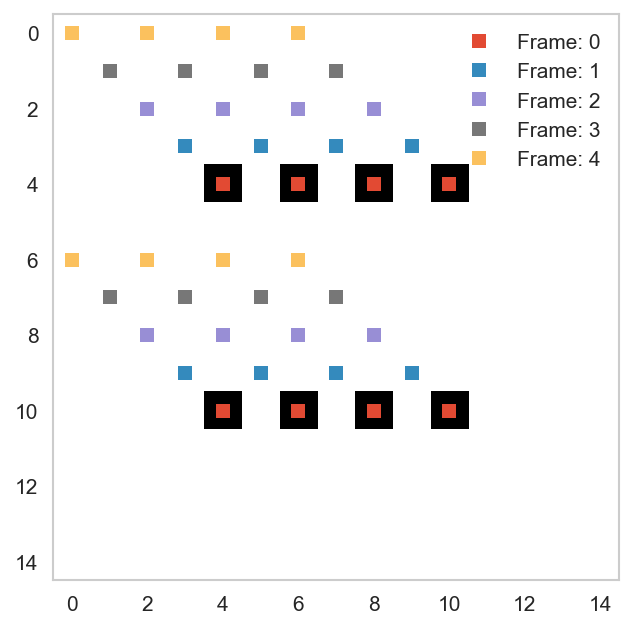

In [54]:
fig, c_ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
c_ax.imshow(disk_img, cmap = 'bone_r')
for frame_idx, c_rows in all_obj_df.groupby('frame_idx'):
    c_ax.plot(c_rows['x'], c_rows['y'], 's', label = 'Frame: %d' % frame_idx)
c_ax.legend();

# Describing Motion
We can describe the motion in the above example with a simple vector

$$ \vec{v}(\vec{x})=\langle -1,-1 \rangle $$


# Scoring Tracking

In the following examples we will use simple metrics for scoring fits where the objects are matched and the number of misses is counted.

There are a number of more sensitive scoring metrics which can be used, by finding the best submatch for a given particle since the number of matches and particles does not always correspond. See the papers at the beginning for more information


```{r track_code}
source('../common/trackingCode.R')
source('../common/data/simFlow.R')
```

# Tracking: Nearest Neighbor

While there exist a number of different methods and complicated approaches for tracking, for experimental design it is best to start with the simplist, easiest understood method. The limits of this can be found and components added as needed until it is possible to realize the experiment
- If a dataset can only be analyzed with a multiple-hypothesis testing neural network model then it might not be so reliable

We then return to _nearest neighbor_ which means we track a point ($\vec{P}_0$) from an image ($I_0$) at $t_0$ to a point ($\vec{P}_1$) in image ($I_1$) at $t_1$ by 

$$ \vec{P}_1=\textrm{argmin}(||\vec{P}_0-\vec{y}||  \;\forall \vec{y}\in I_1) $$

# Random Appearance / Disappearance


Under perfect imaging and experimental conditions objects should not appear and reappear but due to 
- noise
- limited fields of view / depth of field
- discrete segmentation approachs
- motion artifacts
 - blurred objects often have lower intensity values than still objects

It is common for objects to appear and vanish regularly in an experiment.



```{r many-random-dis, fig.height=9}
many.frames<-ldply(seq(0,1.,length.out=9),function(in.offset) {
  c.grid<-test.grid[sample(nrow(test.grid), 18), ]
  cbind(
    make.spheres(data.frame(x=c.grid$x,y=c.grid$y+in.offset,r=c.grid$r)),
    offset=in.offset
    )
})
ggplot(subset(many.frames,phase),aes(x,y))+
  geom_raster(fill="gray50",alpha=0.75)+
  coord_equal()+
  facet_wrap(~offset)+
  labs(title="Different Frames in Linear Flow Image")+
  theme_bw(20)
```

# Jitter / Motion Noise

Even perfect spherical objects do not move in a straight line. The jitter can be seen as a stochastic variable with a random magnitude ($a$) and angle ($b$). This is then sampled at every point in the field

$$ \vec{v}(\vec{x})=\vec{v}_L(\vec{x})+||a||\measuredangle b $$

```{r many-jitter, fig.height=7}
ggplot(subset(make.spheres(test.grid),phase),aes(x,y))+
  geom_raster(fill="gray50",alpha=0.75)+
  geom_segment(data=cbind(test.grid,
                          xv=0+runif(nrow(test.grid),min=-0.05,max=0.05),
                          yv=0.1+runif(nrow(test.grid),min=-0.05,max=0.05)),
               aes(xend=x+xv,yend=y+yv),arrow=arrow(length = unit(0.3,"cm")))+
  coord_equal()+
  theme_bw(20)
```

# Jitter (Continued)


Over many frames this can change the path significantly

```{r many-jitter-continued, fig.height=9}
last.frame<-test.grid[,c("x","y","r")]
last.frame$id<-1:nrow(last.frame)
many.frames<-cbind(make.spheres(last.frame),offset=0)
many.grids<-cbind(last.frame,offset=0)

for(in.offset in cumsum(rep(0.2,8))) {
  last.frame<-with(last.frame,
                   data.frame(x=x+runif(nrow(last.frame),min=-0.1,max=0.1),
                              y=y+0.2+runif(nrow(last.frame),min=-0.1,max=0.1),
                              r=r)
                   )
  
  last.frame$id<-1:nrow(last.frame)
  
  many.frames<-rbind(many.frames,
                     cbind(make.spheres(last.frame),offset=in.offset)
                     )
  
  many.grids<-rbind(many.grids,
                    cbind(last.frame,offset=in.offset)
                    )
}
ggplot(subset(many.frames,phase),aes(x,y))+
  geom_raster(fill="gray50",alpha=0.75)+
  coord_equal()+
  facet_wrap(~offset)+
  labs(title="Different Frames in Linear Flow Image")+
  theme_bw(20)
```



The simulation can be represented in a more clear fashion by using single lines to represent each spheroid 
```{r, fig.height=9}
ggplot(many.grids,aes(x,y,))+
  geom_path(aes(color=id,group=id))+
  coord_equal()+
  labs(title="Different Paths in Linear Jittered Flow Image")+
  scale_color_gradientn(colours=rainbow(10))+
  theme_bw(20)
```

# Limits of Tracking

We see that visually tracking samples can be difficult and there are a number of parameters which affect the ability for us to clearly see the tracking.
- flow rate
- flow type
- density
- appearance and disappearance rate 
- jitter
- particle uniqueness




We thus try to quantify the limits of these parameters for different tracking methods in order to design experiments better. 

### Acquisition-based Parameters

- acquisition rate $\rightarrow$ flow rate, jitter (per frame)
- resolution $\rightarrow$ density, appearance rate


### Experimental Parameters

- experimental setup (pressure, etc) $\rightarrow$ flow rate/type 
- polydispersity $\rightarrow$ particle uniqueness
- vibration/temperature $\rightarrow$ jitter
- mixture $\rightarrow$ density

# Basic Simulations


Input flow from simulation

$$ \vec{v}(\vec{x})=\langle 0,0,0.05 \rangle+||0.01||\measuredangle b $$
```{r basic_flow}
# Generate a simple synthetic dataset
in.frames<-generate.frames(base.rand=0.01,crop.size=c(-10,10),n.objects=20,n.frames=10,flow.rate=0.05,force.2d=T) 

all.tracks<-track.frames(in.frames,offset=c(0,0,0.1),run.offset=T,run.adaptive=T,maxVolPenalty=NA)
```

```{r, fig.height=7}
ggplot(do.call(rbind,in.frames),
       aes(x=POS_X,y=POS_Z,color=as.factor(REAL_LACUNA_NUMBER)))+
  geom_path(aes(linetype="Original"))+
  labs(x="X Position",y="Z Position",color="Object ID",title="Flow Simulation Results")+
  theme_bw(20)
```



Nearest Neighbor Tracking

```{r, fig.height=9}
ggplot(do.call(rbind,in.frames),
       aes(x=POS_X,y=POS_Z,color=as.factor(REAL_LACUNA_NUMBER)))+
  #geom_path(aes(linetype="Original"))+
  geom_path(data=subset(all.tracks,Matching=="No Offset"),aes(linetype="Tracked"),size=2,alpha=0.5)+
  facet_wrap(~Matching)+
  labs(x="X Position",y="Z Position",color="Object ID",title="Tracking Results")+
  theme_bw(20)
```

# More Complicated Flows


Input flow from simulation

$$ \vec{v}(\vec{x})=\langle 0,0,0.01 \rangle+||0.05||\measuredangle b $$
```{r complicated}
# Generate a simple synthetic dataset
in.frames<-generate.frames(base.rand=0.1,crop.size=c(-10,10),n.objects=20,n.frames=20,flow.rate=0.01,
                           force.2d=T,rand.fun=function(x,min=0,max=1) rnorm(x,(min+max)/2,(max-min)/2)) 
all.tracks<-track.frames(in.frames,offset=c(0,0,0.1),run.offset=T,run.adaptive=T,maxVolPenalty=NA)
```

```{r, fig.height=7}
ggplot(do.call(rbind,in.frames),
       aes(x=POS_X,y=POS_Z,color=as.factor(REAL_LACUNA_NUMBER)))+
  geom_path(aes(linetype="Original"))+
  labs(x="X Position",y="Z Position",color="Object ID",title="Flow Simulation Results")+
  theme_bw(20)
```



Nearest Neighbor Tracking

```{r, fig.height=9}
ggplot(do.call(rbind,in.frames),
       aes(x=POS_X,y=POS_Z,color=as.factor(REAL_LACUNA_NUMBER)))+
  geom_path(aes(linetype="Original"))+
  geom_path(data=subset(all.tracks,Matching=="No Offset"),aes(linetype="Tracked"),size=2,alpha=0.5)+
  facet_wrap(~Matching)+
  labs(x="X Position",y="Z Position",color="Object ID",title="Tracking Results")+
  theme_bw(20)
```

# Registration

Before any meaningful tracking tasks can be performed, the first step is to register the measurements so they are all on the same coordinate system. 

Often the registration can be done along with the tracking by separating the movement into actual sample movement and other (camera, setup, etc) if the motion of either the sample or the other components can be well modeled.

## Quantifying Tracking Rate

We can then quantify the success rate of each algorithm on the data set using the very simple match and mismatch metrics

```{r, fig.height=9}
c.tracks<-subset(all.tracks,Matching=="No Offset")
c.tracks<-all.tracks
c.subtrack<-subset(c.tracks,abs(D_REAL_LACUNA_NUMBER)>0)
ggplot(do.call(rbind,in.frames),
       aes(x=POS_X,y=POS_Z))+
  geom_path(aes(linetype="Original",color=as.factor(REAL_LACUNA_NUMBER)))+
  geom_path(data=c.tracks,aes(linetype="Tracked",color=as.factor(REAL_LACUNA_NUMBER)),size=2,alpha=0.5)+
  geom_point(data=c.subtrack,aes(shape="Missed"),size=5,alpha=0.5,color="red")+
  facet_wrap(~Matching)+
  labs(x="X Position",y="Z Position",color="Object ID",title="Tracking Results",fill="Misses")+
  theme_bw(20)

```


### Counting Misses

```{r, fig.height=4}
c.tracks<-subset(all.tracks,Matching=="No Offset")
c.tracks<-all.tracks
c.subtrack<-subset(c.tracks,abs(D_REAL_LACUNA_NUMBER)>0)
ggplot(do.call(rbind,in.frames),
       aes(x=POS_X,y=POS_Z))+
  stat_binhex(data=c.subtrack,bins=5,alpha=1)+
  scale_fill_gradient2(low="white",high="red")+
  facet_wrap(~Matching)+
  labs(x="X Position",y="Z Position",color="Object ID",title="Tracking Results",fill="Misses")+
  theme_bw(20)

```

```{r, results='asis'}
pout<-function(x) paste(round(1000*(1-mean(x)))/10,"%",sep="")
match.table<-ddply.cutcols(all.tracks,.(cut_interval(sample,10)),function(all.sample) { 
    data.frame(
               BIJ_MATCHA=with(subset(all.sample,Matching=="No Offset"),pout(BIJ_MATCH)),
               BIJ_MATCHB=with(subset(all.sample,Matching=="Fix Offset"),pout(BIJ_MATCH)),
               BIJ_MATCHC=with(subset(all.sample,Matching=="Adaptive Offset"),pout(BIJ_MATCH))
               )
    })

names(match.table)<-c("Time","NN","ONN","ANN")
kable(match.table)
```

## Jitter Sensitivity


```{r, fig.height=9,fig.width=14}
match.qual<-function(in.tracks) ddply(in.tracks,.(Matching),function(c.subset) {
  data.frame(Obj.Matched=sum(c.subset$D_REAL_LACUNA_NUMBER==0),
              Obj.Missed=sum(abs(c.subset$D_REAL_LACUNA_NUMBER)>0))
})
rand.fun.norm<-function(n,minv,maxv) rnorm(n,(maxv+minv)/2,(maxv-minv)/2)
n.iters<-4
z.vel<-0.1
n.frames<-2


jd.gen.fun<-function(c.jitter,c.obj.count,...) {
  test.data<-generate.frames(base.rand=c.jitter*z.vel,crop.size=c(-10,10),n.objects=c.obj.count,n.frames=n.frames,rand.fun=rand.fun.norm,...) 
  test.tracks<-track.frames(test.data,offset=c(0,0,z.vel),run.offset=T,run.adaptive=T,maxVolPenalty=NA)
  cbind(jitter=c.jitter,obj.count=c.obj.count,
        mean_obj_spacing=((1/c.obj.count)^0.33)/z.vel,
        match.qual(test.tracks))
}
jitter.vals<-rep(seq(0,2.5,length.out=10),n.iters)
jitter.full<-
jitter.summary.3d<-ddply(ldply(jitter.vals,function(c.jitter) jd.gen.fun(c.jitter,20)),
                      .(jitter,Matching),
                      function(c.subset) {
  data.frame(Matched=100*sum(c.subset$Obj.Matched)/(sum(c.subset$Obj.Missed)+sum(c.subset$Obj.Matched)))
})
jitter.summary.2d<-ddply(ldply(jitter.vals,function(c.jitter) jd.gen.fun(c.jitter,20,force.2d=T)),
                      .(jitter,Matching),
                      function(c.subset) {
  data.frame(Matched=100*sum(c.subset$Obj.Matched)/(sum(c.subset$Obj.Missed)+sum(c.subset$Obj.Matched)))
})
 ggplot(rbind(cbind(jitter.summary.3d,geom="3D"),cbind(jitter.summary.2d,geom="2D")),
        aes(x=100*jitter,y=Matched,color=geom))+
  geom_line()+geom_point()+facet_wrap(~Matching)+
  theme_bw(24)+labs(x="Position Jitter (% of Velocity)",y="% of Bubbles Matched",color="Matching Type")
```

# Density and Jitter

```{r dj-simulation}
n.iters<-2

jitter.vals<-seq(0,2,length.out=3)
irseq<-function(a,b,length.out) {1/seq(1/b^(1/3),1/a^(1/3),length.out=length.out)^3} # seq for inverted numbers
obj.count<-irseq(25,2500,length.out=3)

jit.bub<-merge(obj.count,jitter.vals)
jd.vals<-mapply(list,rep(jit.bub[,1],n.iters),rep(jit.bub[,2],n.iters),SIMPLIFY=F)

jd.full<-ldply(jd.vals,
               function(c.in) jd.gen.fun(c.in[[2]],c.in[[1]]))
jd.summary<-ddply(jd.full,.(jitter,mean_obj_spacing,Matching),function(c.subset) {
  data.frame(obj.count=c.subset$obj.count[1],
             Matched=100*sum(c.subset$Obj.Matched)/(sum(c.subset$Obj.Missed)+sum(c.subset$Obj.Matched)),
             obj.matched=sum(c.subset$Obj.Matched),
             obj.found=100*with(c.subset,sum(Obj.Matched)/(n.iters*(n.frames-1)*obj.count[1])))
})
```

```{r plot-dj-simulation, fig.height=9,fig.width=7}
 ggplot(jd.summary,aes(x=100*jitter,y=Matched,color=as.factor(round(100*mean_obj_spacing))))+
  geom_line()+geom_point()+facet_grid(~Matching)+
  theme_bw(24)+labs(x="Position Jitter (% of Velocity)",y="% of Obj Matched",color="Obj.Spacing\n(% of Velocity)")
```



```{r, fig.height=9,fig.width=7}
ggplot(jd.summary,aes(x=100*jitter,y=100*mean_obj_spacing,fill=Matched))+
  geom_tile()+facet_grid(~Matching)+
  labs(x="Position Jitter (% of Velocity)",fill="% of Obj Matched",y="Obj.Spacing (% of Velocity)")+
  theme_bw(10)

```

# Designing Experiments


### How does this help us to design experiments?
- density can be changed by adjusting the concentration of the substances being examined or the field of view
- flow per frame (image velocity) can usually be adjusted by changing pressure or acquisition time
- jitter can be estimated from images

### How much is enough?

- difficult to create one number for every experiment
- 5% error in bubble position 
 - $\rightarrow$ <5% in flow field
 - $\rightarrow$ >20% error in topology
- 5% error in shape or volume
 - $\rightarrow$ 5% in distribution or changes
 - $\rightarrow$ >5% in individual bubble changes
 - $\rightarrow$ >15% for single bubble strain tensor calculations

# Extending Nearest Neighbor


### Bijective Requirement

- We define $\vec{P}_f$ as the result of performing the nearest neigbhor tracking on $\vec{P}_0$
- $$ \vec{P}_f=\textrm{argmin}(||\vec{P}_0-\vec{y} || \forall \vec{y}\in I_1) $$
- We define $\vec{P}_i$ as the result of performing the nearest neigbhor tracking on $\vec{P}_f$
- $$ \vec{P}_i=\textrm{argmin}(||\vec{P}_f-\vec{y} || \forall \vec{y}\in I_0) $$
- We say the tracking is bijective if these two points are the same
- $$ \vec{P}_i \stackrel{?}{=} \vec{P}_0 $$



### Maximum Displacement

$$ \vec{P}_1=\begin{cases} 
||\vec{P}_0-\vec{y} ||<\textrm{MAXD}, & \textrm{argmin}(||\vec{P}_0-\vec{y} || \forall \vec{y}\in I_1) \\
\textrm{Otherwise}, & \emptyset \end{cases}$$

# Extending Nearest Neighbor (Continued)


### Prior / Expected Movement

$$ \vec{P}_1=\textrm{argmin}(||\vec{P}_0+\vec{v}_{offset}-\vec{y} || \forall \vec{y}\in I_1) $$

### Adaptive Movement
Can then be calculated in an iterative fashion where the offset is the average from all of the $\vec{P}_1-\vec{P}_0$ vectors. It can also be performed 
$$ \vec{P}_1=\textrm{argmin}(||\vec{P}_0+\vec{v}_{offset}-\vec{y} || \forall \vec{y}\in I_1) $$

## Beyond Nearest Neighbor


While nearest neighbor provides a useful starting tool it is not sufficient for truly complicated flows and datasets.

### Better Approaches

1. Multiple Hypothesis Testing
Nearest neighbor just compares the points between two frames and there is much more information available in most time-resolved datasets. This approach allows for multiple possible paths to be explored at the same time and the best chosen only after all frames have been examined



### Shortcomings

1. Merging and Splitting Particles
The simplicity of the nearest neighbor model does really allow for particles to merge and split (relaxing the bijective requirement allows such behavior, but the method is still not suited for such tracking). For such systems a more specific, physically-based is required to encapsulate this behavior.

# Voxel-based Approaches

For voxel-based approachs the most common analyses are digital image correlation (or for 3D images digital volume correlation), where the correlation is calculated between two images or volumes.

### Standard Image Correlation

Given images $I_0(\vec{x})$ and $I_1(\vec{x})$ at time $t_0$ and $t_1$ respectively. The correlation between these two images can be calculated

$$ C_{I_0,I_1}(\vec{r})=\langle I_0(\vec{x}) I_1(\vec{x}+\vec{r}) \rangle $$



```{r, fig.height=5}
# so everything is on an integer lattice (interpolation makes everything messier)
fix.grid<-function(in.grid) { 
  cols.nopos<-!(names(in.grid) %in% c("x","y"))
  out.grid<-in.grid[,cols.nopos]
  out.grid$x<-as.numeric(as.factor(in.grid$x))
  out.grid$y<-as.numeric(as.factor(in.grid$y))
  out.grid
}
start.grid<-grid.list(5)
start.img<-fix.grid(make.spheres(start.grid,base.gr=seq(-1,1,length.out=40)))
final.grid<-data.frame(x=with(start.grid,x),y=with(start.grid,y+0.1),r=start.grid$r)
final.img<-fix.grid(make.spheres(final.grid,base.gr=seq(-1,1,length.out=40)))
ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)

```

## Random Image Positions

With highly structured / periodic samples identfying a best correlation is difficult since there are multiple maxima. 

```{r, fig.height=8}
start.grid<-rand.list(12)
start.img<-fix.grid(make.spheres(start.grid,base.gr=seq(-1,1,length.out=30)))

final.grid<-data.frame(x=with(start.grid,x),y=with(start.grid,y+0.2),r=start.grid$r)
final.img<-fix.grid(make.spheres(final.grid,base.gr=seq(-1,1,length.out=30)))

ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)
```



```{r, fig.height=9}

cc.points<-expand.grid(vx=seq(-8,8,1),vy=seq(-8,8,1))
cc.img<-ddply(cc.points,.(vx,vy),function(c.pt) {
  tr.x<-function(x,y) (x+c.pt[1,"vx"])
  tr.y<-function(x,y) (y+c.pt[1,"vy"])
  cc.imfun(start.img,final.img,tr.x=tr.x,tr.y=tr.y)
})
```

```{r, fig.height=5}
ggplot(cc.img,aes(vx,vy,fill=e.val))+
  geom_raster()+geom_density2d(data=subset(cc.img,e.val>0),aes(weight=e.val^2))+
  labs(x="u",y="v",fill="Correlation",title="Correlation vs r")+
  scale_fill_gradient2(high="red")+
  theme_bw(25)
```

Extending Correlation
===
The correlation function can be extended by adding rotation and scaling terms to the offset making the tool more flexible but also more computationally expensive for large search spaces. 

$$ C_{I_0,I_1}(\vec{r},s,\theta)= $$
$$ \langle I_0(\vec{x}) I_1(
\begin{bmatrix}
s\cos\theta & -s\sin\theta\\
s\sin\theta & s\cos\theta
\end{bmatrix}
\vec{x}+\vec{r}) \rangle  $$



```{r, fig.height=5}

start.grid<-rand.list(15)
rot.th<--pi/4
start.img<-fix.grid(make.spheres(start.grid,base.gr=seq(-1,1,length.out=60)))
final.grid<-data.frame(x=0.9*with(start.grid,cos(rot.th)*x-sin(rot.th)*y),
                       y=0.9*with(start.grid,cos(rot.th)*y+sin(rot.th)*x),r=start.grid$r)
final.img<-fix.grid(make.spheres(final.grid,base.gr=seq(-1,1,length.out=60)))
ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)

```


```{r }
cc.points<-expand.grid(theta=seq(0,pi/2,length.out=8),a=seq(0.7,1,length.out=5))
mid.pt<-c(20,20)
cc.img<-ddply(cc.points,.(theta,a),function(c.pt) {
  tr.x<-function(x,y) 
    (c.pt[1,"a"]*(cos(c.pt[1,"theta"])*(x-mid.pt[1])-sin(c.pt[1,"theta"])*(y-mid.pt[2]))+mid.pt[1])
  tr.y<-function(x,y) 
    (c.pt[1,"a"]*(sin(c.pt[1,"theta"])*(x-mid.pt[1])+cos(c.pt[1,"theta"])*(y-mid.pt[2]))+mid.pt[1])
  cc.imfun(start.img,final.img,tr.x=tr.x,tr.y=tr.y)
})
```

```{r, fig.height=5}
ggplot(cc.img,aes(theta*180/pi,a*100,fill=e.val))+
  geom_raster()+geom_density2d(data=subset(cc.img,e.val>0),aes(weight=e.val))+
  labs(x="Rotation (deg)",y="Scale (%)",fill="Correlation",title="Correlation vs R")+
  scale_fill_gradient2(high="red")+
  theme_bw(25)
```

# More Complicated Changes


```{r, fig.height=7}
start.grid<-rand.list(20)
start.img<-fix.grid(make.spheres(start.grid,base.gr=seq(-1,1,length.out=30)))

final.grid<-data.frame(x=with(start.grid,sign(x)*abs(x)^1.5),y=with(start.grid,sign(y)*abs(y)^1.5),r=start.grid$r)
final.img<-fix.grid(make.spheres(final.grid,base.gr=seq(-1,1,length.out=30)))

ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)
```



```{r, fig.height=9}
cc.points<-expand.grid(vx=seq(-6,6,1),vy=seq(-6,6,1))
cc.img<-ddply(cc.points,.(vx,vy),function(c.pt) {
  tr.x<-function(x,y) (x+c.pt[1,"vx"])
  tr.y<-function(x,y) (y+c.pt[1,"vy"])
  cc.imfun(start.img,final.img,tr.x=tr.x,tr.y=tr.y)
})                            
```

```{r, fig.height=5}                                                                                                                                                                                                                                                                
ggplot(subset(cc.img,count>0),aes(vx,vy,fill=e.val))+
  geom_raster()+geom_density2d(data=subset(cc.img,e.val>0),aes(weight=e.val^2))+
  labs(x="u",y="v",fill="Correlation",title="Correlation vs r")+
  scale_fill_gradient2(high="red")+
  theme_bw(25)
```

# Subdividing the data

We can approach the problem by subdividing the data into smaller blocks and then apply the digital volume correlation independently to each block.
- information on changes in different regions
- less statistics than a larger box

# Choosing a window size

```{r blockify_code}
blockify.img<-function(in.img,nx=5,ny=5,block.fn=function(c.block) c.block,...) {
  out.img<-ddply(in.img,.(cut_interval(x,nx),cut_interval(y,ny)),block.fn,...)
  names(out.img)[c(1:2)]<-c("x.block","y.block")
  out.img$label.block<-with(out.img,paste(x.block,y.block,sep=","))
  cutlabel.fixer<-function(oVal) {
    sapply(oVal,function(x) {
      cnv<-as.character(x)
      mean(as.numeric(strsplit(substr(cnv,2,nchar(cnv)-1),",")[[1]]))
      })
    }
  out.img$x.center<-cutlabel.fixer(out.img$x.block)
  out.img$y.center<-cutlabel.fixer(out.img$y.block)
  out.img
}
```

```{r, fig.height=7}
start.img.blocks<-blockify.img(start.img,4,4)
final.img.blocks<-blockify.img(final.img,4,4)

comb.img.blocks<-rbind(cbind(start.img.blocks,time=0),
                cbind(final.img.blocks,time=1))

ggplot(subset(comb.img.blocks,phase),aes(x,y,fill=as.factor(time)))+
  geom_raster(alpha=0.75)+
  facet_grid(y.block~x.block,scales="free",as.table=F)+
  theme_bw(10)
```



```{r block.corr}
#' Calculate the cross correlation 
#' @author Kevin Mader (kevin.mader@gmail.com)
#' Generates flow with given object count, frame count and randomness
#' the box and crop are introduced to allow for objects entering and 
#' leaving the field of view
#'
#' @param bulk.img the image passed from the blockify command
#' @param f.img is the template image to compare against (since we want the whole image not just a region)
#' @param nsize is the size of the region to search
#' @param nstep is the step to use
block.corr.fun<-function(bulk.img,s.img,nsize=6,nstep=2) {
    cc.points<-expand.grid(vx=seq(-nsize,nsize,nstep),vy=seq(-nsize,nsize,nstep))
    ddply(cc.points,.(vx,vy),function(c.pt) {
        tr.x<-function(x,y) (x+c.pt[1,"vx"])
        tr.y<-function(x,y) (y+c.pt[1,"vy"])
        cc.imfun(s.img,bulk.img,tr.x=tr.x,tr.y=tr.y)
    })
}
w.bcf<-function(s.img,nsize=7,nstep=2) function(cur.block) block.corr.fun(cur.block,s.img,nsize=nsize,nstep=nstep)
max.corr.val<-function(in.blocks) ddply(in.blocks,.(x.center,y.center),function(in.block) {
  subset(in.block,e.val>=max(in.block$e.val) & count>0)
})
```

```{r, fig.height=7}
corr.img.blocks<-blockify.img(final.img,4,4,block.fn=w.bcf(start.img))
ggplot(corr.img.blocks,aes(vx,vy,fill=e.val))+
  geom_raster()+geom_density2d(data=subset(corr.img.blocks,e.val>0),aes(weight=e.val^2))+
  coord_equal()+facet_grid(y.block~x.block,as.table=F)+
  scale_fill_gradient2(high="red")+
  labs(fill="Correlation")+
  theme_bw(10)

```

## Overlap

```{r, fig.height=9,fig.width=14}
max.block.vals<-max.corr.val(corr.img.blocks)
ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  geom_point(data=max.block.vals,aes(x.center,y.center),color="green",size=2)+
  geom_segment(data=max.block.vals,aes(x.center,y.center,xend=x.center+vx,yend=y.center+vy),
               arrow=arrow(length = unit(0.3,"cm")))+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)
```

## Too large of a window

```{r, fig.height=7}
start.img.blocks<-blockify.img(start.img,2,2)
final.img.blocks<-blockify.img(final.img,2,2)
ggplot()+
  geom_raster(data=subset(start.img.blocks,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img.blocks,phase),aes(x,y,fill="1"),alpha=0.75)+
  facet_grid(y.block~x.block,scales="free",as.table=F)+
  labs(fill="time")+
  theme_bw(10)
```


```{r, fig.height=7}
corr.img.blocks<-blockify.img(final.img,2,2,block.fn=w.bcf(start.img))
ggplot(corr.img.blocks,aes(vx,vy,fill=e.val))+
  geom_raster()+geom_density2d(data=subset(corr.img.blocks,e.val>0),aes(weight=e.val^2))+
  coord_equal()+facet_grid(y.block~x.block,as.table=F)+
  scale_fill_gradient2(high="red")+
  labs(fill="Correlation")+
  theme_bw(10)
```

## Overlap

```{r, fig.height=9,fig.width=14}
max.block.vals<-max.corr.val(corr.img.blocks)
ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  geom_point(data=max.block.vals,aes(x.center,y.center),color="green",size=2)+
  geom_segment(data=max.block.vals,aes(x.center,y.center,xend=x.center+vx,yend=y.center+vy),
               arrow=arrow(length = unit(0.3,"cm")))+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)
```

## Too small of a window

```{r, fig.height=7}
start.img.blocks<-blockify.img(start.img,8,8)
final.img.blocks<-blockify.img(final.img,8,8)

ggplot()+
  geom_raster(data=subset(start.img.blocks,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img.blocks,phase),aes(x,y,fill="1"),alpha=0.75)+
  facet_grid(y.block~x.block,scales="free",as.table=F)+
  labs(fill="time")+
  theme_bw(10)
```


```{r, fig.height=7}
corr.img.blocks<-blockify.img(final.img,8,8,block.fn=w.bcf(start.img,4))
ggplot(corr.img.blocks,aes(vx,vy,fill=e.val))+
  geom_raster()+geom_density2d(data=subset(corr.img.blocks,e.val>0),aes(weight=e.val^2))+
  coord_equal()+facet_grid(y.block~x.block,as.table=F)+
  scale_fill_gradient2(high="red")+
  labs(fill="Correlation")+
  theme_bw(10)
```

## Overlap

```{r, fig.height=9,fig.width=14}
max.block.vals<-max.corr.val(corr.img.blocks)
ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  geom_point(data=max.block.vals,aes(x.center,y.center),color="green",size=2)+
  geom_segment(data=max.block.vals,aes(x.center,y.center,xend=x.center+vx,yend=y.center+vy),
               arrow=arrow(length = unit(0.3,"cm")))+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)
```

## Shearing


```{r, fig.height=7}
start.grid<-rand.list(25)
start.img<-fix.grid(make.spheres(start.grid,base.gr=seq(-1,1,length.out=30)))

final.grid<-data.frame(x=with(start.grid,x+y/5),y=with(start.grid,y),r=start.grid$r)
final.img<-fix.grid(make.spheres(final.grid,base.gr=seq(-1,1,length.out=30)))

ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)
```



```{r, fig.height=9,fig.width=14}
corr.img.blocks<-blockify.img(final.img,5,5,block.fn=w.bcf(start.img,4,2))
max.block.vals<-max.corr.val(corr.img.blocks)
ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  geom_point(data=max.block.vals,aes(x.center,y.center),color="green",size=2)+
  geom_segment(data=max.block.vals,aes(x.center,y.center,xend=x.center+vx,yend=y.center+vy),
               arrow=arrow(length = unit(0.3,"cm")))+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)
```

## Compression


```{r, fig.height=7}
start.grid<-rand.list(40)
start.img<-fix.grid(make.spheres(start.grid,base.gr=seq(-1,1,length.out=40)))

final.grid<-data.frame(x=with(start.grid,x),y=with(start.grid,y),r=start.grid$r/2)
final.img<-fix.grid(make.spheres(final.grid,base.gr=seq(-1,1,length.out=40)))

ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)
```



```{r, fig.height=9,fig.width=14}
corr.img.blocks<-blockify.img(final.img,10,10,block.fn=w.bcf(start.img,4))
max.block.vals<-max.corr.val(corr.img.blocks)
ggplot()+
  geom_raster(data=subset(start.img,phase),aes(x,y,fill="0"),alpha=0.75)+
  geom_raster(data=subset(final.img,phase),aes(x,y,fill="1"),alpha=0.75)+
  geom_point(data=max.block.vals,aes(x.center,y.center),color="green",size=2)+
  geom_segment(data=max.block.vals,aes(x.center,y.center,xend=x.center+vx,yend=y.center+vy),
               arrow=arrow(length = unit(0.3,"cm")))+
  coord_equal()+
  labs(fill="time")+
  theme_bw(20)
```

# Introducing Physics


DIC or DVC by themselves include no _sanity check_ for realistic offsets in the correlation itself. The method can, however be integrated with physical models to find a more optimal solutions.

- information from surrounding points
- smoothness criteria
- maximum deformation / force
- material properties



$$ C_{\textrm{cost}} = \underbrace{C_{I_0,I_1}(\vec{r})}_{\textrm{Correlation Term}} + \underbrace{\lambda ||\vec{r}||}_{\textrm{deformation term}} $$

# Distribution Metrics


As we covered before distribution metrics like the distribution tensor can be used for tracking changes inside a sample. Of these the most relevant is the texture tensor from cellular materials and liquid foam. The texture tensor is the same as the distribution tensor except that the edges (or faces) represent physically connected / touching objects rather than touching Voronoi faces (or conversely Delaunay triangles).

These metrics can also be used for tracking the behavior of a system without tracking the single points since most deformations of a system also deform the distribution tensor and can thus be extracted by comparing the distribution tensor at different time steps. 

# Quantifying Deformation: Strain 


We can take any of these approaches and quantify the deformation using a tool called the strain tensor. Strain is defined in mechanics for the simple 1D case as the change in the length against the change in the original length.
$$ e = \frac{\Delta L}{L} $$ 
While this defines the 1D case well, it is difficult to apply such metrics to voxel, shape, and tensor data. 

# Strain Tensor

There are a number of different ways to calculate strain and the strain tensor, but the most applicable for general image based applications is called the [infinitesimal strain tensor](http://en.wikipedia.org/wiki/Infinitesimal_strain_theory), because the element matches well to square pixels and cubic voxels.

```{r, fig.height=6}
b.sq.ele<-0.4*data.frame(dx=c(-1,1,1,-1,-1),dy=c(-1,-1,1,1,-1))
s.grid<-expand.grid(x=c(0:3),y=c(0:3))
sq.eles<-ddply(cbind(s.grid,id=1:nrow(s.grid)),.(x,y),function(in.pt) {
  data.frame(x=in.pt[1,"x"]+b.sq.ele$dx,
             y=in.pt[1,"y"]+b.sq.ele$dy,
             id=in.pt[1,"id"])
})
ggplot(sq.eles,aes(x,y))+
  geom_polygon(aes(group=id))+
  coord_equal()+
  theme_bw(25)
```


A given strain can then be applied and we can quantify the effects by examining the change in the small element. 

```{r, fig.height=6}
s.grid<-expand.grid(x=c(0:3),y=c(0:3))
rh.eles<-ddply(cbind(s.grid,id=1:nrow(s.grid)),.(x,y),function(in.pt) {
  out.df<-data.frame(x=in.pt[1,"x"]+b.sq.ele$dx/(in.pt[1,"x"]+1),
             y=in.pt[1,"y"]+b.sq.ele$dy/(in.pt[1,"y"]+1),
             id=in.pt[1,"id"],
             x.rel.sz=1,
             y.rel.sz=1,
             x.sz=1/(in.pt[1,"y"]+1),
             y.sz=1/(in.pt[1,"x"]+1))
  out.df$e11<-with(out.df,(x.sz-x.rel.sz)/x.rel.sz)
  out.df$e22<-with(out.df,(y.sz-y.rel.sz)/y.rel.sz)
  out.df$e12<-0.5*with(out.df,(x.sz-x.rel.sz)/y.rel.sz+(y.sz-y.rel.sz)/x.rel.sz)
  
  out.df$vol<-with(out.df,e11+e22)
  out.df$dva<-with(out.df,sqrt((e11-vol/2)^2+(e22-vol/2)^2))
  out.df
})
ggplot(rh.eles,aes(x,y))+
  geom_polygon(aes(group=id))+
  coord_equal()+
  theme_bw(25)
```

# Types of Strain

We catagorize the types of strain into two main catagories:

$$ \underbrace{\mathbf{E}}_{\textrm{Total Strain}} = \underbrace{\varepsilon_M \mathbf{I_3}}_{\textrm{Volumetric}} + \underbrace{\mathbf{E}^\prime}_{\textrm{Deviatoric}} $$

### Volumetric / Dilational

The isotropic change in size or scale of the object. 

### Deviatoric

The change in the proportions of the object (similar to anisotropy) independent of the final scale



```{r, fig.height=4}
ggplot(rh.eles,aes(x,y))+
  geom_polygon(aes(group=id,fill=vol),color="black")+
  coord_equal()+
  labs(fill="Volumetric\nStrain")+
  scale_fill_gradient2()+
  theme_bw(25)
```

```{r, fig.height=4}
ggplot(rh.eles,aes(x,y))+
  geom_polygon(aes(group=id,fill=dva),color="black")+
  coord_equal()+
  labs(fill="Deviatoric\nStrain")+
  scale_fill_gradient2()+
  theme_bw(25)
```

# Two Point Correlation - Volcanic Rock


__Data provided by Mattia Pistone and Julie Fife__
The air phase changes from small very anisotropic bubbles to one large connected pore network. The same tools cannot be used to quantify those systems. Furthermore there are motion artifacts which are difficult to correct.

<video controls>
  <source src="ext-figures/roicurv.m4v" type="video/m4v">
Your browser does not support the video tag.
</video>



We can utilize the two point correlation function of the material to characterize the shape generically for each time step and then compare.

<video controls>
  <source src="ext-figures/rdfanim.m4v" type="video/m4v">
Your browser does not support the video tag.
</video>